# Convolutional Neural Networks (CNN)

## Reading an image

Here you can see how we are reading the images and separing it by color channels (RGB)

Shape of the image tensor: (630, 1200, 3)


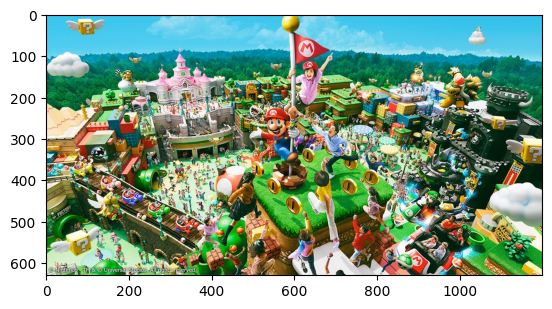

In [1]:
import imageio.v3 as imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Read image
im = imageio.imread("https://super-nintendo-world.usj.co.jp/assets/ogp/ogp_1200x630.jpg")
print("Shape of the image tensor: {}".format(im.shape))
plt.imshow(im)

(630, 1200)


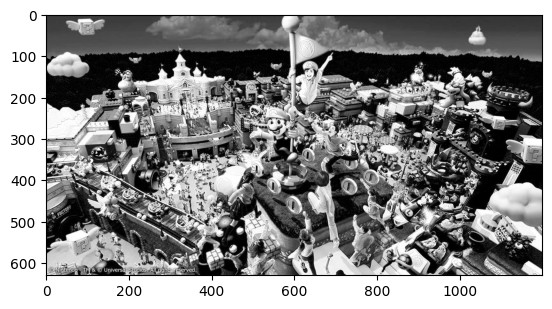

In [2]:
# Red channel
im_red = im[:,:,0]
print(im_red.shape)
plt.imshow(im_red, cmap='gray')

(630, 1200)


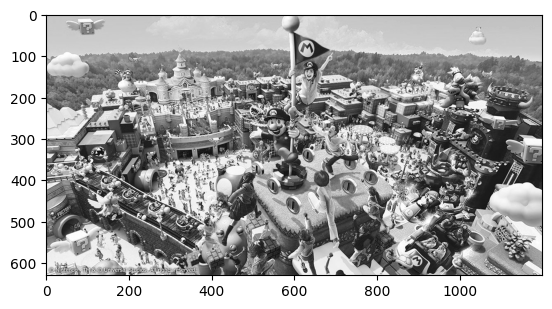

In [3]:
# Green channel
im_green = im[:,:,1]
print(im_green.shape)
plt.imshow(im_green, cmap='gray')

(630, 1200)


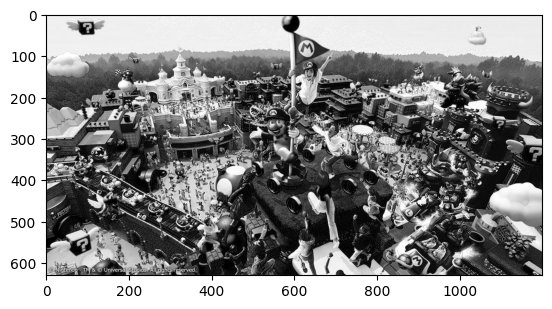

In [4]:
# Blue channel
im_blue = im[:,:,2]
print(im_blue.shape)
plt.imshow(im_blue, cmap='gray')

## Convolutions

In [5]:
import numpy as np
import torch
import torch.nn.functional as F

Fully connected layer

Here you can see how we are just applying matrix operation without convolution

In [6]:
# Create a random flat input vector
x_fc = torch.randn(100, 784)

# Create weight matrix variable
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Create bias variable
b = torch.zeros(10, requires_grad=True)

# Apply fully connected layer
y_preact = torch.matmul(x_fc, W) + b
y = F.relu(y_preact)

# Print input/output shape
print("Input shape: {}".format(x_fc.shape))
print("Output shape: {}".format(y.shape))

Input shape: torch.Size([100, 784])
Output shape: torch.Size([100, 10])


#### Convolutional layer

In a convolutional layer, we convolve the input $x$ with a convolutional kernel (aka filter), which we also call $W$, producing output $y$:

\begin{align*}
y = \text{ReLU}(W*x + b)
\end{align*}

In the context of CNNs, the output $y$ is often referred to as feature maps. As with a fully connected layer, the goal is to learn $W$ and $b$ for our model.

Unlike the input of a fully connected layer, which is $x \in \mathbb R^{M\times C_{in}}$, the dimensionality of an image input is 4D: $x \in \mathbb R^{M \times C_{in} \times H_{in} \times W_{in}}$, where $M$ is still the batch size, $C_{in}$ is the number of channels of the input (e.g. 3 for RGB), and $H_{in}$ and $W_{in}$ are the height and width of the image.

The weight parameter $W$ is also different in a convolutional layer.
Unlike the 2-D weight matrix for fully connected layers, the kernel is 4-D with dimensions $W \in \mathbb R^{C_{out} \times C_{in} \times H_K \times W_K }$, where $H_K$ and $W_K$ are the kernel height and weight, respectively.
A common choice for $H_K$ and $W_K$ is $H_K = W_K = 3$ or $5$, but this tends to vary depending on the architecture.
Convolving the input with the kernel and adding a bias then gives an output $y \in \mathbb R^{M \times C_{out} \times H_{out} \times W_{out}}$.
If we use "same" padding and a stride of $1$ in our convolution (more on this later), our output will have the same spatial dimensions as the input: $H_{out}=H_{in}$ and $W_{out}=W_{in}$.

If you're having trouble visualizing this operation in 4D, it's easier to think about for a single member of the minibatch, one convolutional kernel at a time. 
Consider a stack of $C_{out}$ number of kernels, each of which are 3D ($C_{in} \times H_K \times W_K $). 
This 3D volume is then slid across the input (which is also 3D: $C_{in} \times H_{in} \times W_{in}$) in the two spatial dimensions (along $H_{in}$ and $W_{in}$). 
The outputs of the multiplication of the kernel and the input at every location creates a single feature map that is $H_{out} \times W_{out}$. 
Stacking the feature maps generated by each kernel gives the 3D output $C_{out} \times H_{out} \times W_{out} $.
Repeat the process for all $M$ inputs in the minibatch, and we get a 4D output $M  \times C_{out} \times H_{out} \times W_{out}$.

<img src="https://miro.medium.com/max/640/1*CpgY8KPV8oGDPEtyaiXXPg.webp" alt="Convolutional filters" style="width: 400px;"/>

A few more things to note:
- Notice the ordering of the dimensions of the input (batch, channels in, height, width).
This is commonly referred to as $NCHW$ ordering.
Many other languages and libraries (e.g. MATLAB, TensorFlow, the image example at the beginning of this notebook) instead default to the slightly different $NHWC$ ordering.
PyTorch defaults to $NCHW$, as it more efficient computationally, especially with CUDA. 
- An additional argument for the convolution is the *stride*, which controls the how far we slide the convolutional filter as we move it along the input image. 
The convolutional operator, from its signal processing roots, by default considers a stride length of 1 in all dimensions, but in some situations we would like to consider strides more than 1 (or even less than 1). 
More on this later.
- In the context of signal processing, convolutions usually result in outputs that are larger than the input size, which results from when the kernel "hangs off the edge" of the input on both sides. 
This might not always be desirable.
We can control this by controlling the padding of the input.
Typically, we use pad the input to ensure the output has the same spatial dimensions as the input (assuming stride of 1); this makes it easier for us to keep track of what the size of our model is.

Let's implement this convolution operator in code.
There is a convolution implementation in `torch.nn.functional`, which we use here.



formula for computing the output size of a convolutional layer. We have the following input:

* An image of dimensions $W_{in} \times H_{in}$.
* A filter of dimensions $K \times K$.
* Stride $S$ and padding $P$.


The output activation map will have the following dimensions:

* $\mathbf{W_{out} = \frac{W_{in} - K + 2P}{S} + 1}$
* $\mathbf{H_{out} = \frac{H_{in} - K + 2P}{S} + 1}$

If the output dimensions are not integers, it means that we haven’t set the stride S correctly.

We have two exceptional cases:

When there is no padding at all, the output dimensions are $\left(\frac{W_{in} - K}{S} + 1, \frac{H_{in} - K}{S} + 1\right)$.
In case we want to keep the size of the input unchanged after the convolution layer, we apply same padding where $W_{out} = W_{in}$ and $H_{out} = H_{in}$. If $s=1$, we set $p = \frac{K-1}{2}$.

[Reference](https://www.baeldung.com/cs/convolutional-layer-size)

In [7]:
# Create a random image input tensor
x_cnn = torch.randn(100, 1, 28, 28) #NCHW

# Create convolutional kernel variable
W1 = torch.randn(16, 1, 3, 3)/np.sqrt(1*3*3)
W1.requires_grad_()

# Create bias variable
b1 = torch.zeros(16, requires_grad=True)

# Apply convolutional layer
conv1_preact = F.conv2d(x_cnn, W1, bias=b1, stride=1, padding=1)
conv1 = F.relu(conv1_preact)

# Print input/output shape
print("Input shape: {}".format(x_cnn.shape))
print("Convolution output shape: {}".format(conv1.shape))

Input shape: torch.Size([100, 1, 28, 28])
Convolution output shape: torch.Size([100, 16, 28, 28])


Note that we need to change the dimensions of the convolutional kernel such that its input channels matches the number of output channels of the previous layer:

In [8]:
# 2nd layer variables
W2 = torch.randn(32, 16, 3, 3)/np.sqrt(16*3*3)
W2.requires_grad_()
b2 = torch.zeros(32, requires_grad=True)

# Apply 2nd convolutional layer
conv2 = F.relu(F.conv2d(conv1, W2, bias=b2, stride=1, padding=1))

# Print output shape
print("Second convolution output shape: {}".format(conv2.shape))

Second convolution output shape: torch.Size([100, 32, 28, 28])


## Reshaping
You'll commonly finding yourself needing to reshape tensors while building CNNs. The PyTorch function for doing so is view(). Anyone familiar with NumPy will find it very similar to np.reshape(). Importantly, the new dimensions must be chosen so that it is possible to rearrange the input into the shape of the output (i.e. the total number of elements must be the same). As with NumPy, you can optionally replace one of the dimensions with a -1, which tells torch to infer the missing dimension

[Documentation](https://pytorch.org/docs/master/tensor_view.html)
[See this stack overflow explanation](https://stackoverflow.com/questions/42479902/what-does-view-do-in-pytorch/42482819#42482819)

In [9]:
M = torch.zeros(4, 3)

M2 = M.view(1,1,12)
M3 = M.view(2,1,2,3)
M4 = M.view(-1,2,3)
M5 = M.view(-1)

In [10]:
# Reshape flat input image into a 4D batched image input
x_flat = torch.randn(100, 784)
x_reshaped = x_flat.view(-1, 1, 28, 28)

# Print input shape
print(x_reshaped.shape)

torch.Size([100, 1, 28, 28])


In [11]:
# Flatten convolutional feature maps into a vector
h_flat = conv2.view(-1, 28*28*32)

# Print output shape
print(h_flat.shape)

torch.Size([100, 25088])


## Pooling and striding
![](https://epynn.net/_images/pool-01.svg)

In [12]:
# Recreate values in pooling figure and make it 4D
feature_map_fig = torch.tensor(np.array([[1,1,2,4],
                                        [5,6,7,8],
                                        [3,2,1,0],
                                        [1,2,3,4]], dtype=np.float32))
fmap_fig = feature_map_fig.view(1,1,4,4)
print("Feature map shape pre-pooling: {}".format(fmap_fig.shape))

# Maxpool
max_pool_fig = F.max_pool2d(fmap_fig, kernel_size=2)
print("\nMax pool")
print("Shape: {}".format(max_pool_fig.shape))
print(torch.squeeze(max_pool_fig))

# Avgpool
avg_pool_fig = F.avg_pool2d(fmap_fig, kernel_size=2)
print("\nAvg pool")
print("Shape: {}".format(avg_pool_fig.shape))
print(torch.squeeze(avg_pool_fig))

Feature map shape pre-pooling: torch.Size([1, 1, 4, 4])

Max pool
Shape: torch.Size([1, 1, 2, 2])
tensor([[6., 8.],
        [3., 4.]])

Avg pool
Shape: torch.Size([1, 1, 2, 2])
tensor([[3.2500, 5.2500],
        [2.0000, 2.0000]])


In [13]:
# Since striding is part of the convolution operation, we'll start with the feature maps before the 2nd convolution
print("Shape of conv1 feature maps: {0}".format(conv1.shape))

# Apply 2nd convolutional layer, with striding of 2
conv2_strided = F.relu(F.conv2d(conv1, W2, bias=b2, stride=2, padding=1))

# Print output shape
print("Shape of conv2 feature maps with stride of 2: {0}".format(conv2_strided.shape))

Shape of conv1 feature maps: torch.Size([100, 16, 28, 28])
Shape of conv2 feature maps with stride of 2: torch.Size([100, 32, 14, 14])


## Building CNN

In [14]:
import torch.nn as nn

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # fc layer 1
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = F.relu(x)
        
        # fc layer 2
        x = self.fc2(x)
        return x     

In [15]:
model = MNIST_CNN()
print(model)

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


[Adam](https://arxiv.org/abs/1412.6980) was used.

To learn more about 1D, 2D and 3D convolutions, check [here](https://wandb.ai/ayush-thakur/dl-question-bank/reports/Intuitive-understanding-of-1D-2D-and-3D-convolutions-in-convolutional-neural-networks---VmlldzoxOTk2MDA)

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model  
model = MNIST_CNN()  # <---- change here

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # <---- change here

# Iterate through train set minibatchs 
for epoch in trange(3):  # <---- change here
    for images, labels in tqdm(train_loader):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = images  # <---- change here 
        y = model(x)
        loss = criterion(y, labels)
        # Backward pass
        loss.backward()
        optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images  # <---- change here 
        y = model(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9876000285148621


## Torchvision

The [torchvision](https://pytorch.org/vision/stable/index.html) package consists of popular datasets, model architectures, and common image transformations for computer vision.
Torchvision includes easy-to-use APIs for downloading and loading many popular vision datasets. We've previously seen this in action for downloading the MNIST dataset:

### Leveraging popular convolutional neural networks

While you certainly can build your own custom CNNs like we did above, more often than not, it's better to use one of the popular existing architectures. The Torchvision documentation has a list of supported CNNs, as well as some performance characteristics. There's a number of reasons for using one of these CNNs instead of designing your own.

First, for image datasets larger and more complex than MNIST (which is basically all of them), a fair amount network depth and width is often necessary. For example, some of the popular CNNs can be over 100 layers deep, with several tricks and details beyond what we've covered in this notebook. Coding all of this yourself has a high potential for error, especially when you're first getting started. Instead, you can create the CNN architecture using Torchvision, using a couple lines:

In [18]:
import torchvision.models as models
resnet18 = models.resnet18()
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Loading a working CNN architecture in a couple lines can save a significant amount of time both implementing and debugging.

The second, perhaps even more important, reason to use one of these existing architectures is the ability to use pre-trained weights. Early on in the recent resurgence of deep learning, people discovered that the weights of a CNN trained for ImageNet classification were highly transferable. For example, it is common to use the weights of an ImageNet-trained CNN as a weight initialization for other vision tasks, or even to freeze the bulk of the weights and only re-train the final classification layer(s) on a new task. This is significant, as in most settings, we rarely have enough labeled data to train a powerful CNN from scratch without overfitting. 

### Other computer vision tasks
The base CNN architectures were often designed for image classification, but the same CNNs are often used as the backbone of most modern computer vision models. These other models often take this base CNN and include additional networks or make other architecture changes to adapt them to other tasks, such as object detection. Torchvision contains a few models (and pre-trained weights) for object detection, segmentation, and video action recognition. For example, to load a Faster R-CNN with a ResNet50 convolutional feature extractor with Feature Pyramid Networks pre-trained on MS COCO

In [ ]:
# object_detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)